In [1]:
repo_path = 'D:\ProjGit\plinko\plinko_nn'

In [2]:
import sys
sys.path.append(repo_path + '/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot
from plinko.model.mlp import MLP
from plinko.misc import utils

from plotnine import * #ggplot, geom_point, aes, labs
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [4]:
def createStates(df_ball, df_env, df_col,device):
    collisions = df_col.copy()
    collisions = collisions.rename({'object': 'collision'}, axis=1)
    collisions.t -= 1

    collisions = df_ball.merge(collisions, how='left')
    # collisions = collisions[~collisions.collision.isna()]
    collisions.collision[collisions.collision.isna()] = 'none'
    collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200)] = 'left_wall'
    collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
    collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
    collisions = collisions.sort_values(['simulation', 'run', 't'])

    env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
                   'rectangle_x', 'rectangle_y', 'rectangle_r',
                   'pentagon_x', 'pentagon_y', 'pentagon_r']
    envs = collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]

    idx2col = sorted(collisions.collision.unique())
    col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

    states = torch.tensor(collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
    targets = torch.tensor([col2idx[c] for c in collisions.collision], dtype=torch.long, device=device)
    envs = torch.tensor(envs.values, dtype=torch.float, device=device)

    return states,targets,envs, idx2col, col2idx

In [5]:
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1

collisions = df_ball.merge(collisions, how='left')
#collisions = collisions[~collisions.collision.isna()]
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
collisions = collisions.sort_values(['simulation', 'run', 't'])


env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
               'rectangle_x', 'rectangle_y', 'rectangle_r',
               'pentagon_x', 'pentagon_y','pentagon_r']
envs = collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]

idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

states = torch.tensor(collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
targets = torch.tensor([col2idx[c] for c in collisions.collision], dtype=torch.long, device=device)
envs = torch.tensor(envs.values, dtype=torch.float, device=device)

# old versions
df_envs2 = df_env.copy()
df_envs2['triangle_rsin'] = np.sin(df_env['triangle_r'])
df_envs2['triangle_rcos'] = np.cos(df_env['triangle_r'])
df_envs2['rectangle_rsin'] = np.sin(df_env['rectangle_r'])
df_envs2['rectangle_rcos'] = np.cos(df_env['rectangle_r'])
df_envs2['pentagon_rsin'] = np.sin(df_env['pentagon_r'])
df_envs2['pentagon_rcos'] = np.cos(df_env['pentagon_r'])

env_trig_columns = ['triangle_x', 'triangle_y', 'triangle_rsin','triangle_rcos',
               'rectangle_x', 'rectangle_y', 'rectangle_rsin','rectangle_rcos',
               'pentagon_x', 'pentagon_y','pentagon_rsin', 'pentagon_rcos']
envs_trig = collisions.merge(df_envs2).sort_values(['simulation', 'run', 't'])[env_trig_columns]

In [6]:
model = MLP(input_size=[9, 4],
            hidden_layer_size=[16,16,16,16,16],
            activation=F.elu,
            output_size=len(idx2col)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
epochs = 2000

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()
    
    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch%100 == 0:
        print(epoch, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

0 2.4775 0.1234
100 0.8833 0.6729
200 0.5614 0.7892
300 0.4043 0.8618
400 0.3084 0.8962
500 0.2545 0.915
600 0.2127 0.9313
700 0.1808 0.9423
800 0.1556 0.9503
900 0.1354 0.9578
1000 0.1221 0.9612
1100 0.1137 0.9644
1200 0.107 0.9661
1300 0.1013 0.9691
1400 0.0977 0.9707
1500 0.0938 0.9711
1600 0.0913 0.9729
1700 0.0898 0.9721
1800 0.0865 0.9727
1900 0.0835 0.9748
2000 0.0811 0.9754



In [7]:
savename = repo_path + '/experiments/collisions/mlp'
torch.save(model.state_dict(), savename + '.model')

In [8]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars='epoch', var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_point(aes(x='epoch', y='accuracy', color='collision'))
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)

print(accuracies[accuracies['epoch']==3000])

Empty DataFrame
Columns: [epoch, collision, accuracy]
Index: []


[[9.855e-01 3.000e-03 5.500e-03 0.000e+00 0.000e+00 6.000e-03 0.000e+00]
 [2.000e-03 9.980e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.200e-02 6.500e-03 8.800e-01 9.000e-03 2.700e-02 3.700e-02 1.850e-02]
 [0.000e+00 0.000e+00 2.000e-03 9.975e-01 0.000e+00 5.000e-04 0.000e+00]
 [0.000e+00 0.000e+00 9.500e-03 5.000e-04 9.900e-01 0.000e+00 0.000e+00]
 [1.300e-02 0.000e+00 3.500e-03 0.000e+00 0.000e+00 9.835e-01 0.000e+00]
 [0.000e+00 0.000e+00 6.000e-03 0.000e+00 5.000e-04 0.000e+00 9.935e-01]]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

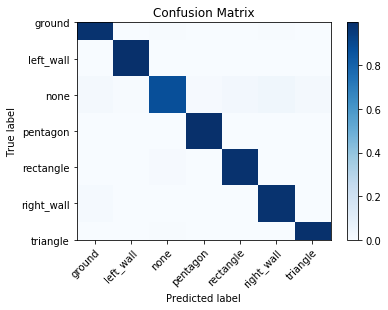

In [9]:
cm = confusion_matrix(targets.cpu(), outputs.argmax(-1).cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize
classes = idx2col

print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

['ground', 'left_wall', 'none', 'pentagon', 'rectangle', 'right_wall', 'triangle']
[[9.775e-01 4.000e-03 6.000e-03 0.000e+00 0.000e+00 1.250e-02 0.000e+00]
 [2.000e-03 9.980e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.950e-02 1.450e-02 8.310e-01 2.550e-02 4.000e-02 2.800e-02 3.150e-02]
 [0.000e+00 0.000e+00 6.000e-03 9.940e-01 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 1.400e-02 0.000e+00 9.835e-01 1.000e-03 1.500e-03]
 [1.600e-02 0.000e+00 4.000e-03 0.000e+00 0.000e+00 9.800e-01 0.000e+00]
 [0.000e+00 0.000e+00 4.500e-03 0.000e+00 5.000e-04 0.000e+00 9.950e-01]]


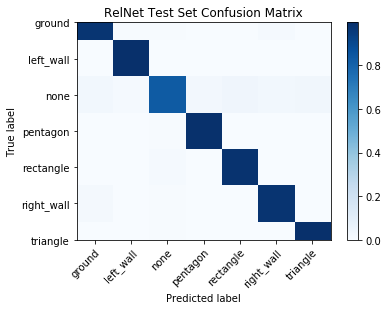

In [30]:
# sample new test set
states_test,targets_test,envs_test, idx2col, col2idx = createStates(df_ball, df_env, df_col,device)

savename = repo_path + '/experiments/collisions/mlp'

#model = relNet(state_size = 4, state_hn = 4, state_embed_size=32,
#                obj_size = 3, obj_hn = 4,obj_embed_size=16,
#                obj_n = 3, nullobj_n = 4,
#                mlp_hsize = 16, mlp_hn=3, mlp_outsize=1).to(device)
#model.load_state_dict(torch.load(savename + '.model'))
#model.eval()
outputs = model(envs_test, states_test)

cm = confusion_matrix(targets_test.cpu(), outputs.argmax(-1).cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize
classes = idx2col
print(classes)

print(cm)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='RelNet Test Set Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

s = 'mlp_testconfusion'
path = repo_path + '/experiments/collisions/'
plt.savefig(path+s)

In [36]:
average_acc = np.mean([9.775e-01,9.980e-01,8.310e-01,9.940e-01,9.835e-01,9.800e-01,9.950e-01])
print('average_acc = ' + str(average_acc))
collision_acc = np.mean([9.940e-01,9.835e-01,9.950e-01])
print('collision_acc = ' + str(collision_acc))
wall_collision_acc = np.mean([9.980e-01,9.800e-01])
print('wall_collision_acc = ' + str(wall_collision_acc))

average_acc = 0.9655714285714285
collision_acc = 0.9908333333333333
wall_collision_acc = 0.989
